In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf



In [2]:
# 1) Load
df = pd.read_csv("/home/limorgu/coding/replications/replication_paper/data/input/helpimpactcheckE4.csv", sep=";")  # or the full path

# 2) Player A subset and recodes
PlayerA = df[df["Condition"].isin([3,4])].copy()
PlayerA["conditionA"] = (PlayerA["Condition"] == 3).astype(int)

# Ensure columns exist even if missing (defensive)
for c in ["checkObs","checkHid","calcHelp","uncalcHelp"]:
    if c not in PlayerA.columns:
        PlayerA[c] = np.nan


In [3]:
# 3) Coalesce to get the actual checking indicator (1=checked, 0=did not check)
PlayerA["checking"] = PlayerA["checkObs"].fillna(PlayerA["checkHid"])
PlayerA["helping"]  = PlayerA["calcHelp"].fillna(PlayerA["uncalcHelp"])
PlayerA["checking"] = pd.to_numeric(PlayerA["checking"], errors="coerce").fillna(0).astype(int)
PlayerA["helping"]  = pd.to_numeric(PlayerA["helping"], errors="coerce").fillna(0).astype(int)

# 4) Logistic regression (H5.1): checking ~ conditionA
m = smf.glm("checking ~ conditionA", data=PlayerA, family=sm.families.Binomial()).fit()
print(m.summary())

# Optional: odds ratios + CI

                 Generalized Linear Model Regression Results                  
Dep. Variable:               checking   No. Observations:                 1311
Model:                            GLM   Df Residuals:                     1309
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -640.16
Date:                Tue, 04 Nov 2025   Deviance:                       1280.3
Time:                        10:25:52   Pearson chi2:                 1.31e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.004428
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6094      0.105     15.339      0.0


Odds ratios (95% CI):
                 OR    CI_low   CI_high
Intercept   5.0000  4.070596  6.141607
conditionA  0.7125  0.540380  0.939443

Plot table:
     Condition  Percentage     CI_low    CI_high
0  Observable   78.082192  74.918895  81.245489
1      Hidden   83.333333  80.477105  86.189562


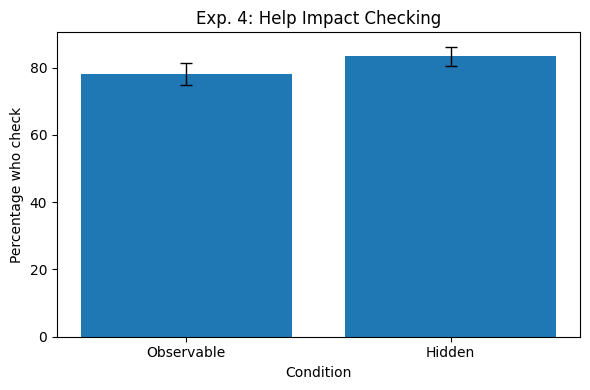

In [5]:
# Optional: odds ratios + CI
params = m.params
conf = m.conf_int()
or_table = pd.DataFrame({
    "OR": np.exp(params),
    "CI_low": np.exp(conf[0]),
    "CI_high": np.exp(conf[1])
})
print("\nOdds ratios (95% CI):\n", or_table)

# 5) Percent who check in each condition + 95% CI (normal approximation)
obs = PlayerA[PlayerA["conditionA"] == 1]
hid = PlayerA[PlayerA["conditionA"] == 0]

p_obs = obs["checkObs"].sum() / len(obs)
p_hid = hid["checkHid"].sum() / len(hid)

checkPercObs = 100*p_obs
checkPercHid = 100*p_hid
z = 1.959963984540054

def ci_pct(p, n):
    lo = 100*(p - z*np.sqrt(p*(1-p)/n))
    hi = 100*(p + z*np.sqrt(p*(1-p)/n))
    return lo, hi

ci_low_obs, ci_high_obs = ci_pct(p_obs, len(obs))
ci_low_hid, ci_high_hid = ci_pct(p_hid, len(hid))

plot_df = pd.DataFrame({
    "Condition": ["Observable","Hidden"],
    "Percentage": [checkPercObs, checkPercHid],
    "CI_low": [ci_low_obs, ci_low_hid],
    "CI_high": [ci_high_obs, ci_high_hid]
})
print("\nPlot table:\n", plot_df)

# 6) Bar chart (matches paper style)
x = np.arange(len(plot_df))
y = plot_df["Percentage"].values
yerr = np.vstack([y - plot_df["CI_low"].values, plot_df["CI_high"].values - y])

plt.figure(figsize=(6,4))
plt.bar(x, y)
plt.errorbar(x, y, yerr=yerr, fmt='none', capsize=4, elinewidth=1, ecolor='black')
plt.xticks(x, plot_df["Condition"].tolist())
plt.ylabel("Percentage who check")
plt.xlabel("Condition")
plt.title("Exp. 4: Help Impact Checking")
plt.tight_layout()
plt.savefig("E4_help_impact_checking.png", dpi=200)
plt.show()

In [ ]:
# player B data - prepare the data
import pandas as pd, numpy as np, statsmodels.formula.api as smf

# Load if not in memory
E4 = pd.read_csv("/home/limorgu/coding/replications/replication_paper/data/input/helpimpactcheckE4.csv", sep=";")

# Player B subset: conditions 5 = observable and 6 = hidden
PlayerB = E4[E4["Condition"].isin([5,6])].copy()

# Recode: 1 = observable, 0 = hidden
PlayerB["conditionB"] = (PlayerB["Condition"] == 5).astype(int)

# --- Select only observable Player B responses (condition B = 1) ---
PlayerB2 = PlayerB[PlayerB["conditionB"] == 1].copy()

# Keep only the decision columns relevant to help/no-help × check/no-check
cols_needed = ["PID","helpUncalc","helpCalc","noUncalc","noCalc"]
for c in cols_needed:
    if c not in PlayerB2.columns:
        PlayerB2[c] = np.nan
PlayerB2 = PlayerB2[cols_needed]

# Convert from wide → long
PlayerB2 = (
    PlayerB2.melt(id_vars="PID", var_name="name", value_name="sent")
      .assign(
          helping = lambda d: d["name"].str.contains("help").astype(int),
          checking = lambda d: d["name"].str.contains("Calc").astype(int)
      )
      .drop(columns="name")
)

# Convert pence to percentage of endowment
PlayerB2["sent"] = np.where(PlayerB2["sent"] >= 1, PlayerB2["sent"] * 100 / 10, PlayerB2["sent"])
PlayerB2.head()


,PID,sent,helping,checking
0,1,60.0,1,0
1,3,50.0,1,0
2,4,100.0,1,0
3,8,70.0,1,0
4,13,60.0,1,0
